<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#0.1-Import-necessary-packages" data-toc-modified-id="0.1-Import-necessary-packages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>0.1 Import necessary packages</a></span></li></ul></li><li><span><a href="#Define-Method-for-Plotting-Acquisition-Images-and-Performing-Target-Acquisition" data-toc-modified-id="Define-Method-for-Plotting-Acquisition-Images-and-Performing-Target-Acquisition-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define Method for Plotting Acquisition Images and Performing Target Acquisition</a></span></li><li><span><a href="#Successful-Target-Acquisition" data-toc-modified-id="Successful-Target-Acquisition-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Successful Target Acquisition</a></span></li><li><span><a href="#Target-Acquisition-Failure-Cases" data-toc-modified-id="Target-Acquisition-Failure-Cases-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Target Acquisition Failure Cases</a></span></li></ul></div>

## Introduction
There are two types of STIS target acquisition: ACQ and ACQ/PEAK. In this notebook, we will go through the steps for ACQ observations, and explore some success and failure cases.


For ACQ observations, the target acquisition data has three science extensions:
- Before Coarse Slew
- Before Fine Slew
- 0.2$\times$0.2 Reference Aperture with HITM lamp

The first science extension (Coarse Phase) of the acquisition raw file is an image of target in the target acquisition sub-array based on initial pointing. Then the coarse centering is performed: the software determines the position of the target with a flux weighted poiting algorithm, and calculates the slew needed to place the target at a reference point in the target acquisition sub-array; the coarse centered image is stored in the second science extension (Fine Phase). The next step is to perform fine centering: a 32 $\times$ 32 pixel image of the reference aperture is obtained and stored in the third science extension (Reference Aperture), the location of the aperture on the detector is determined, and a fine slew is performed to center the taret in the reference aperture (to place the object precisely in a slit).

For more information on ACQ target acquisition, see [`Evaluating Target Acquisitions and Guiding`](https://hst-docs.stsci.edu/stisdhb/chapter-5-stis-data-analysis/5-2-evaluating-target-acquisitions-and-guiding).

### 0.1 Import necessary packages

**We will import the following packages:**

- `astropy.io fits` for accessing FITS files
- `astroquery.mast Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `pathlib`,`os` for managing system paths
- `matplotlib` for plotting data
- `stistools` for quick operations on STIS Data

In [1]:
# Import for: Reading in fits file
from astropy.io import fits

# Import for: Downloading necessary files. (Not necessary if you choose to collect data from MAST)
from astroquery.mast import Observations

# Import for: Managing system variables and paths
from pathlib import Path
import os

# Import for: Plotting and specifying plotting parameters
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from astropy.visualization import ZScaleInterval
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.cmap'] = 'viridis'
matplotlib.rcParams['image.interpolation'] = 'none'
matplotlib.rcParams['figure.figsize'] = (20,7)

# Import for operations on STIS Data
import stistools

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


## Define Method for Plotting Acquisition Images and Performing Target Acquisition

We define a method to plot the three science image extensions mentioned above, and run the stistools_tastis target acquisition method to show the result and associated information of target acquisition.

In [7]:
def acq(obs_id):
    # Search target objscy by obs_id
    target = Observations.query_criteria(obs_id=obs_id)
    # get a list of files assiciated with that target
    acq_list = Observations.get_product_list(target)
    # Download only the _raw fits files
    Observations.download_products(acq_list,productType="SCIENCE",extension='fits')
    raw = os.path.join("./mastDownload/HST","{}".format(obs_id),"{}_raw.fits".format(obs_id))
    
    # plot the acquisition raw images
    with fits.open(raw) as hdu:
        initial = hdu[1].data
        confirm = hdu[4].data
        lamp = hdu[7].data
    zscaler = ZScaleInterval(contrast=0.10).get_limits 
    _, initial_max = zscaler(initial)
    _, confirm_max = zscaler(confirm)
    vmax = max(initial_max,confirm_max)
    
    # plot the initial target position in coarse phase
    TARGA1 = fits.getheader(raw,1)["TARGA1"]
    TARGA2 = fits.getheader(raw,1)["TARGA2"]
    centera1 = fits.getheader(raw,0)["CENTERA1"]
    centera2 = fits.getheader(raw,0)["CENTERA2"]
    sizaxis1 = fits.getheader(raw,0)["sizaxis1"]
    sizaxis2 = fits.getheader(raw,0)["sizaxis2"]
    corner1 = centera1 - sizaxis1/2 
    corner2 = centera2 - sizaxis2/2
    
    
    plt.subplot(1,3,1)
    plt.imshow(initial,vmin = 0,vmax = vmax)
    plt.plot([TARGA1-corner1+1],[TARGA2-corner2+1],"rx")
    plt.title("Coarse Phase")
    plt.subplot(1,3,2)
    plt.imshow(confirm,vmin = 0,vmax = vmax)
    plt.title("Fine Phase")
    plt.subplot(1,3,3)
    plt.imshow(lamp,vmin = 0,vmax = vmax)
    plt.title("Reference Aperture")
    plt.tight_layout()
    
    stistools.tastis.tastis(raw)

## Successful Target Acquisition
Here we present a successful target acquisition case in which the target is correctly selected from the initial pointing image, coarse centering and fine centering are successfully performed, and the target is eventually centered in the slit. The target location, coarse slew, and fine slew data are printed by stistools.tastis. Note here that the coordinate system of tastis is 1-indexed while Python is 0-indexed.

INFO: Found cached file ./mastDownload/HST/octka2daq/octka2daq_raw.fits with expected size 120960. [astroquery.query]
octka2daq       HST/STIS    MIRVIS      F25ND3             ACQ/POINT
prop: 14161      visit: A2    line: 1   target: HD-84937
obs date, time: 2016-04-30    10:09:43   exposure time:  2.10
ACQ params:     bias sub: 1510   checkbox: 3      method: FLUX CENTROID
subarray (axis1,axis2):   size=(100,100)          corner=(487,466)
-------------------------------------------------------------------------------
Coarse locate phase:           Target flux in max checkbox (DN): 3194

                       global          local
                    axis1 axis2     axis1 axis2
Target location:    531.9  516.2    45.9  51.2

                    axis1 axis2     axis1  axis2         V2      V3
                      (pixels)        (arcsec)            (arcsec)
Estimated slew:     -3.8   0.2    -0.196  0.010       -0.131 -0.145
------------------------------------------------------------

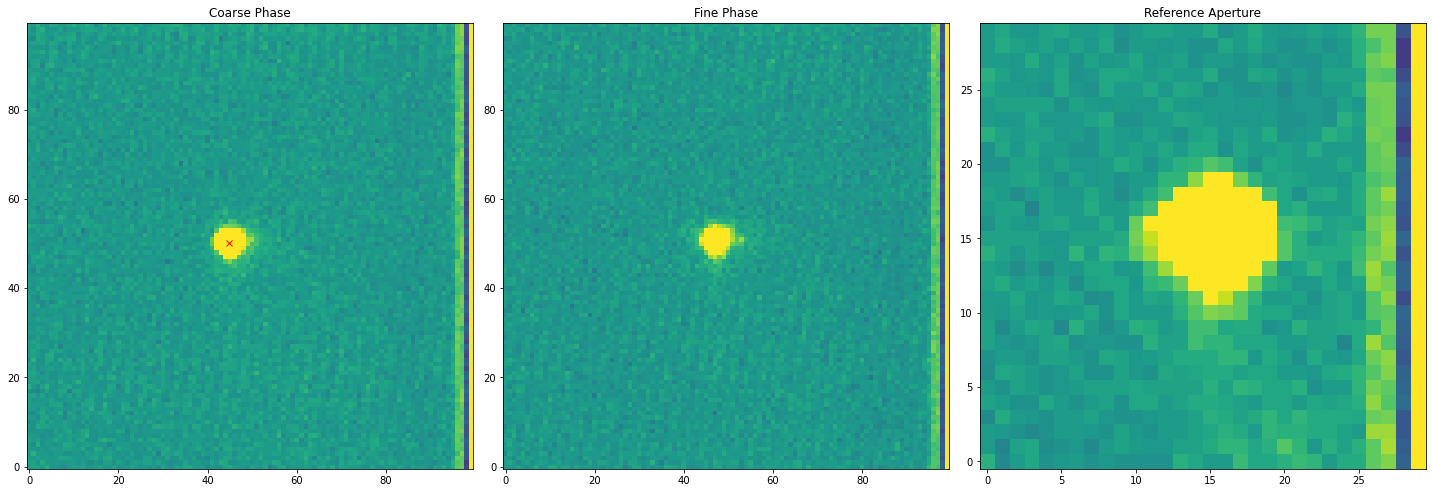

In [9]:
acq("octka2daq")

## Target Acquisition Failure Cases

INFO: Found cached file ./mastDownload/HST/ocyg39yoq/ocyg39yoq_raw.fits with expected size 120960. [astroquery.query]
ocyg39yoq       HST/STIS    MIRVIS     F28X50LP             ACQ/POINT
prop: 14257      visit: 39    line: 1   target: C2013X1
obs date, time: 2016-06-10    12:33:13   exposure time:  2.10
ACQ params:     bias sub: 1510   checkbox: 3      method: FLUX CENTROID
subarray (axis1,axis2):   size=(100,100)          corner=(487,466)
-------------------------------------------------------------------------------
Coarse locate phase:           Target flux in max checkbox (DN): 295

                       global          local
                    axis1 axis2     axis1 axis2
Target location:    537.0  549.0    51.0  84.0

                    axis1 axis2     axis1  axis2         V2      V3
                      (pixels)        (arcsec)            (arcsec)
Estimated slew:      1.3  33.0     0.065  1.676        1.231 -1.140
-------------------------------------------------------------

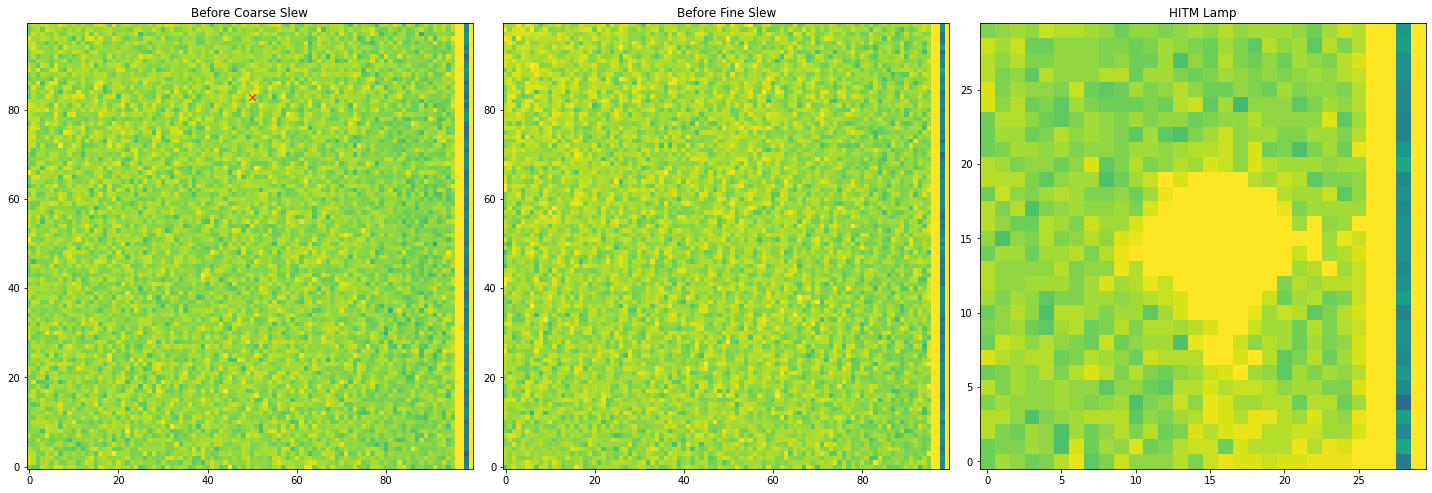

In [28]:
acq("ocyg39yoq")

ocw901lyq       HST/STIS    MIRVIS     F28X50LP             ACQ/POINT
prop: 14211      visit: 01    line: 1   target: MQ1-OFFSET
obs date, time: 2016-07-05    01:52:45   exposure time: 240.10
ACQ params:     bias sub: 1510   checkbox: 3      method: FLUX CENTROID
subarray (axis1,axis2):   size=(100,100)          corner=(487,466)
-------------------------------------------------------------------------------
Coarse locate phase:           Target flux in max checkbox (DN): 1442

                       global          local
                    axis1 axis2     axis1 axis2
Target location:    488.0  504.0     2.0  39.0

                    axis1 axis2     axis1  axis2         V2      V3
                      (pixels)        (arcsec)            (arcsec)
Estimated slew:     -47.7  -12.0    -2.425 -0.610       -2.146 -1.283
-------------------------------------------------------------------------------
Fine locate phase:            Target flux in max checkbox (DN): 1922

                      

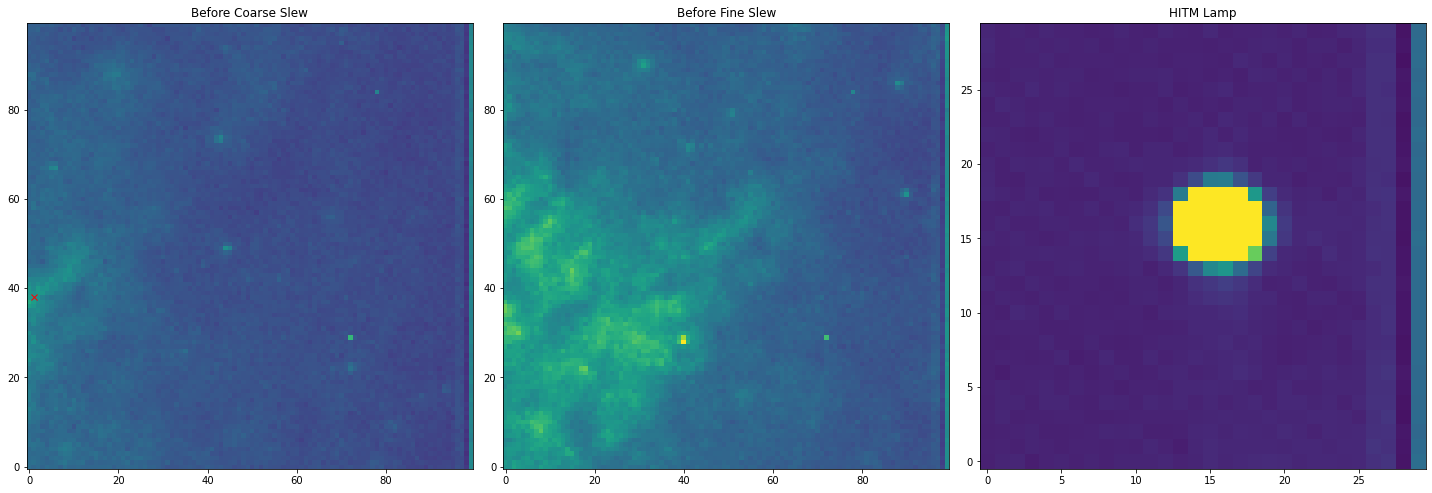

In [30]:
acq("ocw901lyq")